In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
customers_df = pd.read_csv('/kaggle/input/ecommerce-data/Customers.csv')
products_df = pd.read_csv('/kaggle/input/ecommerce-data/Products.csv')
transactions_df = pd.read_csv('/kaggle/input/ecommerce-data/Transactions.csv')

In [3]:
merged_df = pd.merge(transactions_df, customers_df, on='CustomerID', how='left')
merged_df = pd.merge(merged_df, products_df, on='ProductID', how='left')

print(merged_df.head())

merged_df.to_csv('Merged_Data.csv', index=False)

  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3        T00272      C0087      P067  2024-03-26 22:55:37         2   
4        T00363      C0070      P067  2024-03-21 15:10:10         3   

   TotalValue  Price_x     CustomerName         Region  SignupDate  \
0      300.68   300.68   Andrea Jenkins         Europe  2022-12-03   
1      300.68   300.68  Brittany Harvey           Asia  2024-09-04   
2      300.68   300.68  Kathryn Stevens         Europe  2024-04-04   
3      601.36   300.68  Travis Campbell  South America  2024-04-11   
4      902.04   300.68    Timothy Perez         Europe  2022-03-15   

                       ProductName     Category  Price_y  
0  ComfortLiving Bluetooth Speaker  Electronics   300.68  
1  ComfortLiving Bluetooth Speaker

In [4]:
import pandas as pd
from datetime import datetime

merged_df = pd.read_csv('Merged_Data.csv')

merged_df['TransactionDate'] = pd.to_datetime(merged_df['TransactionDate'])
latest_date = merged_df['TransactionDate'].max()

customer_profile = merged_df.groupby('CustomerID').agg({
    'Region': 'first',
    'SignupDate': 'first',
    'TransactionID': 'count',  # TotalTransactions
    'TotalValue': 'sum',       # TotalSpending
    'TransactionDate': lambda x: (latest_date - x.max()).days,  # Recency
    'Category': lambda x: x.mode()[0]  # FavoriteCategory
}).reset_index()

customer_profile['SignupDate'] = pd.to_datetime(customer_profile['SignupDate'])
customer_profile['Tenure'] = (datetime.now() - customer_profile['SignupDate']).dt.days

customer_profile['AverageTransactionValue'] = customer_profile['TotalValue'] / customer_profile['TransactionID']

customer_profile.rename(columns={
    'TransactionID': 'TotalTransactions',
    'TotalValue': 'TotalSpending',
    'TransactionDate': 'Recency',
    'Category': 'FavoriteCategory'
}, inplace=True)

customer_profile.drop(columns=['SignupDate'], inplace=True)

print(customer_profile.head())

  CustomerID         Region  TotalTransactions  TotalSpending  Recency  \
0      C0001  South America                  5        3354.52       55   
1      C0002           Asia                  4        1862.74       25   
2      C0003  South America                  4        2725.38      125   
3      C0004  South America                  8        5354.88        4   
4      C0005           Asia                  3        2034.24       54   

  FavoriteCategory  Tenure  AverageTransactionValue  
0      Electronics     934                  670.904  
1         Clothing    1081                  465.685  
2       Home Decor     328                  681.345  
3            Books     843                  669.360  
4      Electronics     898                  678.080  


In [5]:
customer_profile = pd.get_dummies(
    customer_profile,
    columns=['Region', 'FavoriteCategory'],
    drop_first=True
)

In [6]:
from sklearn.preprocessing import StandardScaler

numerical_features = ['Tenure', 'TotalTransactions', 'TotalSpending', 'AverageTransactionValue', 'Recency']
scaler = StandardScaler()
customer_profile[numerical_features] = scaler.fit_transform(customer_profile[numerical_features])

print(customer_profile.head())

  CustomerID  TotalTransactions  TotalSpending   Recency    Tenure  \
0      C0001          -0.011458      -0.061701 -0.266933  1.148752   
1      C0002          -0.467494      -0.877744 -0.690872  1.600431   
2      C0003          -0.467494      -0.405857  0.722260 -0.713270   
3      C0004           1.356650       1.032547 -0.987630  0.869141   
4      C0005          -0.923530      -0.783929 -0.281064  1.038137   

   AverageTransactionValue  Region_Europe  Region_North America  \
0                -0.070263          False                 False   
1                -0.934933          False                 False   
2                -0.026271          False                 False   
3                -0.076769          False                 False   
4                -0.040028          False                 False   

   Region_South America  FavoriteCategory_Clothing  \
0                  True                      False   
1                 False                       True   
2             

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

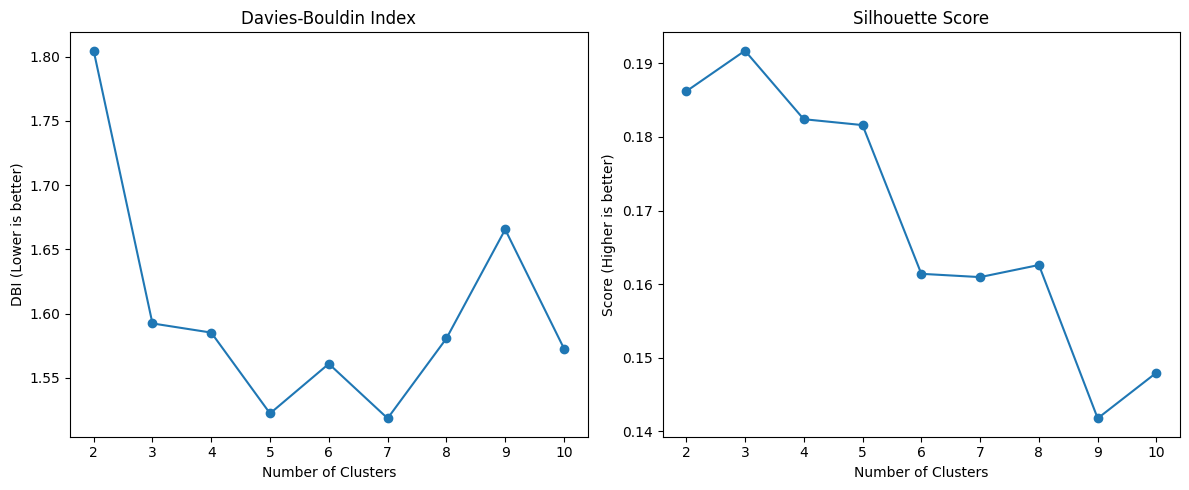

In [7]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score

X = customer_profile.drop(columns=['CustomerID'])

# Test cluster numbers from 2 to 10
db_scores = []
silhouette_scores = []

for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(X)
    
    db_scores.append(davies_bouldin_score(X, labels))
    silhouette_scores.append(silhouette_score(X, labels))

# Plot results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(2, 11), db_scores, marker='o')
plt.title('Davies-Bouldin Index')
plt.xlabel('Number of Clusters')
plt.ylabel('DBI (Lower is better)')

plt.subplot(1, 2, 2)
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Score (Higher is better)')

plt.tight_layout()
plt.show()

In [8]:
# Final clustering
n_clusters = 4  # Replace with your optimal number
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
customer_profile['Cluster'] = kmeans.fit_predict(X)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


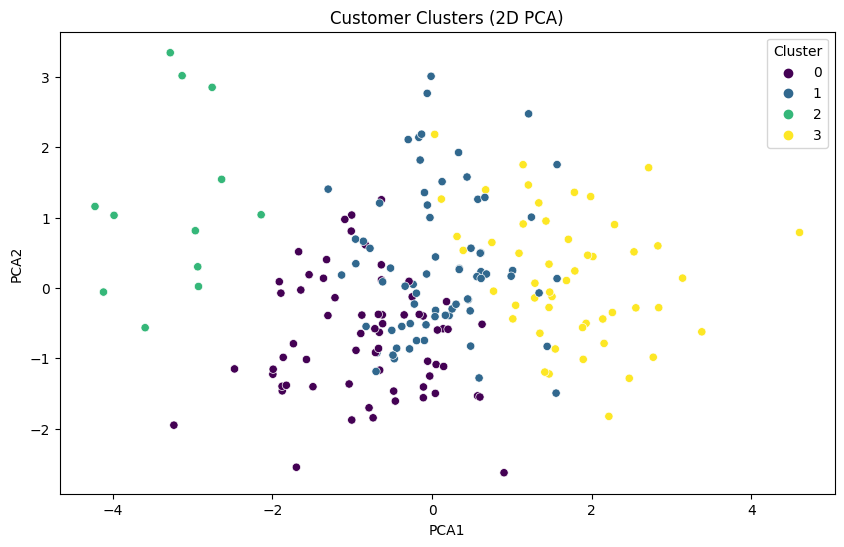

In [9]:
from sklearn.decomposition import PCA

# Reduce to 2D using PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)
customer_profile['PCA1'] = pca_result[:, 0]
customer_profile['PCA2'] = pca_result[:, 1]

# Plot clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='PCA1', y='PCA2',
    hue='Cluster',
    data=customer_profile,
    palette='viridis',
    legend='full'
)
plt.title('Customer Clusters (2D PCA)')
plt.show()

In [10]:
cluster_stats = customer_profile.groupby('Cluster')[numerical_features].mean().reset_index()
print(cluster_stats)

   Cluster    Tenure  TotalTransactions  TotalSpending  \
0        0  0.733378          -0.467494      -0.694926   
1        1 -0.930020           0.051880      -0.013358   
2        2 -0.431099          -1.683590      -1.478348   
3        3  0.489301           0.937097       1.277442   

   AverageTransactionValue   Recency  
0                -0.546414 -0.052572  
1                 0.098983 -0.213940  
2                -0.521777  2.840780  
3                 0.693030 -0.305370  
